# In-graph Training Loop for Classification ─ Horse or Human?

In this notebook we will be training a Keras model on the [horses_or_humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset, with all steps of the training process executed in graph mode. Our training workflow will include:

- **Loading Batches:** Efficiently handling data in batches suitable for processing by our model.
- **Calculating Gradients:** Utilizing TensorFlow's automatic differentiation to compute gradients for each batch.
- **Updating Parameters:** Adjusting the model's weights based on the calculated gradients to minimize loss.
- **Calculating Validation Accuracy:** Measuring the model’s performance on a separate validation dataset to monitor its generalization ability.
- **Repeating the Loop:** Iterating through the training loop until the model converges to a satisfactory accuracy or a specified number of epochs is reached.

This comprehensive approach ensures a thorough understanding of each step involved in training neural networks using TensorFlow in graph mode.

## Setup

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

### Prepare the dataset

To get started, we'll load the horses to human dataset and split it, allocating 80% for the training set and 20% for the test set. This distribution allows us to train our model on a substantial portion of the data while reserving a smaller segment to evaluate its performance and generalization capability. Splitting the data this way helps ensure that our model learns effectively and can accurately predict new, unseen data. Let's proceed by setting up this split and preparing our datasets for the training and testing phases.

In [ ]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

## Pre-process an image

We'll define a mapping function for our dataset that accomplishes two key preprocessing tasks: resizing the images and normalizing the pixel values. This step ensures that all images fed into our model are uniform in size and that their pixel values are scaled appropriately for effective model training.

- **Resizing Images:** We'll use `tf.image.resize` to adjust the images to a consistent height and width of 224 by 224 pixels. This standardization is crucial for the model to process the images uniformly.
- **Normalizing Pixels:** To normalize the pixel values, which originally range from 0 to 255, we'll divide each pixel by 255.0 (ensuring the operation uses float division). This adjustment scales the pixel values to a range of [0,1], which helps in speeding up the convergence during training by maintaining numerical stability.

These preprocessing steps are essential for preparing the data correctly and ensuring that the model receives inputs in a format that optimizes learning.

In [ ]:
# Create a autograph pre-processing function to resize and normalize an image
@tf.function
def map_fn(img, label):
    image_height = 224
    image_width = 224

    # Resize the image
    img = tf.image.resize(img, [image_height, image_width])

    # Normalize the image
    img /= 255.

    return img, label

## Apply pre-processing to the datasets

To properly prepare the training_examples for our model, we'll apply a series of transformations that enhance the effectiveness of our training process:

1. **Mapping Function Application**: First, we apply the `map_fn` to the training_examples. This function, which we've defined to resize and normalize images, will be applied to each example in the dataset, ensuring consistency in input size and pixel value range.

2. **Shuffling the Data**: Next, we'll shuffle the training data to ensure that the learning process does not bias towards any order-dependent patterns. Use the `.shuffle(buffer_size=)` method with the buffer size set to the total number of training examples. This maximizes the randomness during shuffling and ensures that each batch generated during training is different, reducing the risk of overfitting and improving the model's ability to generalize.

3. **Batching the Data**: Finally, group the transformed data into batches using the `.batch()` method, specifying the batch size as given by a parameter. Batching is crucial for training efficiency, as it allows the model to update its parameters incrementally, based on a subset of the data rather than on a single example or the entire dataset at once.

These steps will configure the training data properly, setting up an effective pipeline that feeds well-prepared inputs into our model for training. This pipeline not only optimizes the training process but also plays a significant role in achieving better model performance.

In [ ]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).shuffle(buffer_size=num_examples).batch(batch_size)

    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)

    return train_ds, valid_ds, test_ds

In [ ]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

### Define the model

In [ ]:
MODULE_HANDLE = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build([None, IMAGE_SIZE, IMAGE_SIZE, num_classes])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## Define optimizer

We will use [Adam optimizer] for our model

In [ ]:
def set_adam_optimizer():
    # Define the adam optimizer
    optimizer = tf.keras.optimizers.Adam()

    return optimizer

## Define the loss function

We'll use `SparseCategoricalCrossentropy` from `tf.keras.losses` for both training and validation, ideal for integer-labeled classification tasks, ensuring consistent evaluation across all phases.

In [ ]:
def set_sparse_cat_crossentropy_loss():
    # Define object oriented metric of Sparse categorical crossentropy for train and val loss
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy()

    return train_loss, val_loss

## Define the acccuracy function

For our accuracy function, we will use `SparseCategoricalAccuracy` from `tf.keras.metrics` as our accuracy function for both training and validation. This metric is well-suited for models that handle integer-labeled classes, ensuring uniform accuracy assessment throughout the training process.

In [ ]:
def set_sparse_cat_crossentropy_accuracy():
    # Define object oriented metric of Sparse categorical accuracy for train and val accuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    return train_accuracy, val_accuracy

Having defined the three functions above, let's use them to initialize our optimzer, loss function and accuracy function

In [ ]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

### Define the training loop

In the training loop we will perform the following:
- Obtain the model predictions: utilize the model by inputting `x`.
- Compute the training loss: Invoke `train_loss`, providing the actual `y` values and the predicted `y` values.
- Determine the gradient of the loss concerning the model's variables: employ `tape.gradient`, passing the loss and the model's `trainable_variables`.
- Adjust the model variables using the gradients: execute `optimizer.apply_gradients`, utilizing a `zip()` of two lists: the gradients and the model's `trainable_variables`.
- Evaluate the accuracy: Utilize `train_accuracy`, inputting the actual `y` values and the predicted `y` values.

In [ ]:
# this code uses the GPU if available, otherwise uses a CPU
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
EPOCHS = 2

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    '''
    Trains on a batch of images for one step.

    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training images
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''
    with tf.GradientTape() as tape:
      # Run the model on input x to get predictions
      predictions = model(x)
      # Compute the training loss using `train_loss`, passing in the true y and the predicted y
      loss = train_loss(y, predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_variables)

    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)

    return loss

## Define the 'train' function

We'll first iterate through the training batches to train the model.

- The `train` function will utilize a for loop to iteratively call the `train_one_step` function.
- We'll utilize `tf.print` to display the step number, loss, and `train_accuracy.result()` at each step. Remember to utilize `tf.print` when autograph code generation is intended.

Next, we'll iterate through the batches of the validation set to calculate the validation loss and validation accuracy. The code for this is provided.

At each iteration of the loop:
- Employ the model to make predictions on `x`, where `x` represents the input from the validation set.
- Utilize `val_loss` to compute the validation loss between the true validation `y` and the predicted `y`.
- Utilize `val_accuracy` to compute the accuracy of the predicted `y` compared to the true `y`.

Finally, we'll print the validation loss and accuracy using `tf.print`.

- Print the final `loss`, which is the validation loss calculated during the last iteration through the validation dataset.
- Additionally, print `val_accuracy.result()`.

In [ ]:
# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.

    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # Training step number increments at each iteration
            step += 1

            with tf.device(device_name=device):
              # Run one training step by passing appropriate model parameters
              # required by the function and finally get the loss to report the results
              loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)

            # Printing the training step, loss and accuracy using tf.print
            tf.print('Step', step,
                   ': train loss', loss,
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)

        # Print the validation loss and accuracy
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

Execute the `train` function to initiate the training of our model! Throughout the training process, we should observe the loss generally decreasing and the accuracy increasing.

In [ ]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 0.575667679 ; train accuracy 0.6875
Step 2 : train loss 0.52560693 ; train accuracy 0.6875
Step 3 : train loss 0.202898711 ; train accuracy 0.78125
Step 4 : train loss 0.244570464 ; train accuracy 0.8125
Step 5 : train loss 0.127817407 ; train accuracy 0.84375
Step 6 : train loss 0.146217644 ; train accuracy 0.859375
Step 7 : train loss 0.0614836141 ; train accuracy 0.879464269
Step 8 : train loss 0.0435092673 ; train accuracy 0.89453125
Step 9 : train loss 0.0256168824 ; train accuracy 0.90625
Step 10 : train loss 0.021377733 ; train accuracy 0.915625
Step 11 : train loss 0.0212953016 ; train accuracy 0.923295438
Step 12 : train loss 0.00837307796 ; train accuracy 0.9296875
Step 13 : train loss 0.0104838777 ; train accuracy 0.935096145
Step 14 : train loss 0.00567023316 ; train accuracy 0.939732134
Step 15 : train loss 0.00851730071 ; train accuracy 0.94375
Step 16 : train loss 0.00405717734 ; train accuracy 0.947265625
Step 17 : train loss 0.00507557578 ; train ac

# Evaluation

The model training has finished! We can now assess how our model performs on test images. Let's start by loading the test dataset and generating predictions.

In [ ]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

We'll define a utility function for visualizing an image alongside its prediction.

In [ ]:
class_names = {0:'horse', 1:'human'}

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    # print the true label first
    print('Actual Label :', class_names[true_label])

    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



### Plot the result of a single image

Choose an index and display the model's prediction for that image.

We will choose 8 as the value for our index

Actual Label : horse


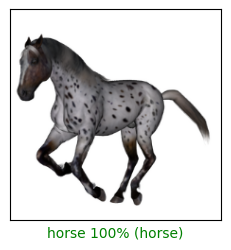

In [ ]:
# Visualize the outputs

# We can modify the index value here from 0 to 255 to test different images
index = 8
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()